<a href="https://colab.research.google.com/github/elOmnia/TM_Ex03/blob/main/Ex03_v2_BERTopic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Exercise 3: Applying a Topic Modeling approach**
by Mariann Burk 	Omnia ElSaadany

This code is adpated from:  

 
**BERTopic - Tutorial** 
We start with installing bertopic from pypi before preparing the data. https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing (last updated 12-04-2021)



**NOTE**: Make sure to select a GPU runtime. Otherwise, the model can take quite some time to create the document embeddings!

In [ ]:
!pip install bertopic[all]

     |████████████████████████████████| 81kB 4.0MB/s 
     |████████████████████████████████| 81kB 5.1MB/s 
     |████████████████████████████████| 6.4MB 9.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 450kB 27.1MB/s 
     |████████████████████████████████| 13.2MB 28.0MB/s 
     |████████████████████████████████| 2.1MB 39.0MB/s 
     |████████████████████████████████| 1.2MB 38.1MB/s 
     |████████████████████████████████| 1.2MB 22.0MB/s 
     |████████████████████████████████| 19.7MB 1.3MB/s 
     |████████████████████████████████| 798kB 33.2MB/s 
     |████████████████████████████████| 983kB 37.4MB/s 
     |████████████████████████████████| 71kB 7.5MB/s 
     |████████████████████████████████| 3.3MB 30.2MB/s 
     |████████████████████████████████| 870kB 37.0MB/s 
  Created wheel for hdbscan: filename=hdbscan-0.8.27-cp37-cp37m-linux_x86_64.whl size=2311729 sh

Import [BERTopic](https://maartengr.github.io/BERTopic/)

In [ ]:
from bertopic import BERTopic

# **Task data**
"The German data from Federal Parliament speeches
from the two political parties SP and SVP from 1999 to 2019. Not all speeches are included, they were filtered by 8 different keywords. You can load the data
with the following modification:
df = pd.read_json('https://files.ifi.uzh.ch/cl/siclemat/lehre/fs21/tm/data/all_de_topics.jsonl', lines=True,
nrows=5563)" ~ Excersie 3 - doc.

In [ ]:
import re, numpy as np, pandas as pd

data_df = pd.read_json('https://files.ifi.uzh.ch/cl/siclemat/lehre/fs21/tm/data/all_de_topics.jsonl', lines=True,
nrows=5563)
print('Speeches from:', pd.unique(data_df.target_names))
print('Total # speeches:', data_df.shape)
# for testing I'll use only 100 rows of SP speeches to start with 
# data_df = data_df.loc[data_df.target_names.isin(['FraktionderSchweizerischenVolkspartei']) , :]
# data_df = data_df[0:100]
# print('filtered # speeches:', data_df.shape)  #> (2361, 3)
data_df.head()

Speeches from: ['FraktionderSchweizerischenVolkspartei' 'SozialdemokratischeFraktion']
Total # speeches: (5563, 2)


,content,target_names
0,"Ich bitte Sie namens der Minderheit, diese Mot...",FraktionderSchweizerischenVolkspartei
1,Die Kommission für Verkehr und Fernmeldewesen ...,FraktionderSchweizerischenVolkspartei
2,"Ich bitte Sie, in dieser Frage dem Weg der Kom...",FraktionderSchweizerischenVolkspartei
3,Der Missbrauch an der Marke Schweiz im In- und...,FraktionderSchweizerischenVolkspartei
4,Auch ich bin für Eintreten auf diese beiden Vo...,FraktionderSchweizerischenVolkspartei


Dropped the target_names column, as we are not interested to use the political parties names in the topic modeling. Similarly, in BERTopic tutorial  using "fetch_20newsgroups" data, they removed the header which contained the sender of this message.

In [ ]:
docs = data_df['content'].tolist()

In [ ]:
docs[0]

'Ich bitte Sie namens der Minderheit, diese Motion abzulehnen.   Natürlich machen wir uns keine Illusion, damit im Rat durchzukommen, vielmehr wird es auf absehbare Zeit einmal der Souverän sein, der grundsätzlich festlegen wird, wie viele Auslandeinsätze die Schweizer Armee leisten soll. Sicher kann man aus dem seinerzeitigen Volksentscheid bei der letzten Revision des Militärgesetzes nicht einfach schliessen, dass der Souverän scheibchenweise - nach Salamitaktik - immer mehr dieser sehr kostenintensiven Auslandeinsätze gewollt habe. Ein Referendum oder eine Volksinitiative soll folglich bei sich bietender Gelegenheit dieses Thema im Volk wieder einmal grundsätzlich zur Diskussion stellen.   Für heute möchte ich Ihnen einfach ein paar Gedanken darlegen, warum die Minderheit diese Motion nicht annehmen kann und ablehnt:   1. Es ist ein offenes Geheimnis, dass wir gar nicht genügend Freiwillige rekrutieren könnten, um die jetzigen Einsätze personell verdoppeln zu können. Oder will man k

## Data preprocessing
This subsection uses the code from https://github.com/Asatas/TM_Ex3/blob/main/TM3.ipynb 

In [ ]:
#run this code once, too
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('german')
# TODO later check if we need to extend with more german stop words
stop_words.extend(['fuer','mehr'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


### Tokenize Sentences and Clean
Removing the emails, new line characters, single quotes and finally split the sentence into a list of words using gensim’s simple_preprocess(). Setting the deacc=True option removes punctuations.

In [ ]:
def sent_to_words(sentences):
    # added this line to handle german umlauts and ss, replacing any umlauts with an extra e. 
    umlaut_map = {ord('ß'):'ss', ord('Ä'):'Ae', ord('Ö'):'oe', ord('Ü'):'Ue', ord('ä'):'ae', ord('ö'):'oe', ord('ü'):'ue'}
    for sent in sentences:
        sent = sent.translate(umlaut_map)
        #sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        # sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
#data = df.content.values.tolist()
data_words = list(sent_to_words(docs))
print(data_words[:1])

['Ich bitte Sie namens der Minderheit, diese Motion abzulehnen. Natuerlich machen wir uns keine Illusion, damit im Rat durchzukommen, vielmehr wird es auf absehbare Zeit einmal der Souveraen sein, der grundsaetzlich festlegen wird, wie viele Auslandeinsaetze die Schweizer Armee leisten soll. Sicher kann man aus dem seinerzeitigen Volksentscheid bei der letzten Revision des Militaergesetzes nicht einfach schliessen, dass der Souveraen scheibchenweise - nach Salamitaktik - immer mehr dieser sehr kostenintensiven Auslandeinsaetze gewollt habe. Ein Referendum oder eine Volksinitiative soll folglich bei sich bietender Gelegenheit dieses Thema im Volk wieder einmal grundsaetzlich zur Diskussion stellen. Fuer heute moechte ich Ihnen einfach ein paar Gedanken darlegen, warum die Minderheit diese Motion nicht annehmen kann und ablehnt: 1. Es ist ein offenes Geheimnis, dass wir gar nicht genuegend Freiwillige rekrutieren koennten, um die jetzigen Einsaetze personell verdoppeln zu koennen. Oder w

### Build the Bigram, Trigram Models and Lemmatize
Let’s form the bigram and trigrams using the Phrases model. This is passed to Phraser() for efficiency in speed of execution.

Next, lemmatize each word to its root form, keeping only nouns, adjectives, verbs and adverbs.

We keep only these POS tags because they are the ones contributing the most to the meaning of the sentences. Here, I use spacy for lemmatization.

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
data_ready

[['festlegen',
  'leisten',
  'volksentscheid',
  'diskussion',
  'stellen',
  'gedanken',
  'lassen',
  'sogenannten',
  'missionsjunkie',
  'leuten',
  'leuten',
  'fluktuation',
  'ersieht',
  'daraus',
  'offiziere',
  'stationiert',
  'eingesetzt',
  'rechnung',
  'fall',
  'bereit',
  'erfuellt',
  'vielleicht',
  'lage',
  'sagen',
  'viele',
  'truppen',
  'gemaess',
  'eben',
  'motion',
  'page',
  'permanent',
  'hochwertige',
  'verzichtet',
  'nochmal',
  'kosten',
  'delegation',
  'gesetzt',
  'schweiz',
  'damal',
  'volksabstimmung',
  'truppen',
  'gehabt',
  'volksabstimmung',
  'spezialisten',
  'hochwertige',
  'material',
  'bewachung',
  'jahr',
  'schicken',
  'pro',
  'eingesetzt',
  'leisten',
  'deshalb',
  'gegenueber',
  'motion'],
 ['delegation',
  'gestellt',
  'dargestellt',
  'diskussion',
  'wurden',
  'durchgefuehrt',
  'bereit',
  'damal',
  'revision',
  'revision',
  'postgesetze',
  'worden',
  'revision',
  'gut',
  'traegt',
  'postgesetz',
  'd

Appending output senetnces' word list to a senetnce for BERT.

In [ ]:
for i in range(len(data_ready)):
  data_ready[i] = ' '.join(data_ready[i])
data_ready

['festlegen leisten volksentscheid diskussion stellen gedanken lassen sogenannten missionsjunkie leuten leuten fluktuation ersieht daraus offiziere stationiert eingesetzt rechnung fall bereit erfuellt vielleicht lage sagen viele truppen gemaess eben motion page permanent hochwertige verzichtet nochmal kosten delegation gesetzt schweiz damal volksabstimmung truppen gehabt volksabstimmung spezialisten hochwertige material bewachung jahr schicken pro eingesetzt leisten deshalb gegenueber motion',
 'delegation gestellt dargestellt diskussion wurden durchgefuehrt bereit damal revision revision postgesetze worden revision gut traegt postgesetz defizit staatlich festgelegten wurden entwurf bundesrate stimman',
 'argument argumenten mehrzahl mitglieder rate hauptargument situation finden allerding direktion voelkerrecht geteilt gemischte erweitert worden staaten unserer seite staaten gemeinschaft unterschiedlich behandeln geteilt stellen abkomman infrage entsprechend wissen vielleicht nochmal 

# **Create Topics**
BERTopic has a multilingual model supports 50+ languages. besides the following languages.

In [ ]:
from bertopic import languages
print(languages)

['afrikaans', 'albanian', 'amharic', 'arabic', 'armenian', 'assamese', 'azerbaijani', 'basque', 'belarusian', 'bengali', 'bengali romanize', 'bosnian', 'breton', 'bulgarian', 'burmese', 'burmese zawgyi font', 'catalan', 'chinese (simplified)', 'chinese (traditional)', 'croatian', 'czech', 'danish', 'dutch', 'english', 'esperanto', 'estonian', 'filipino', 'finnish', 'french', 'galician', 'georgian', 'german', 'greek', 'gujarati', 'hausa', 'hebrew', 'hindi', 'hindi romanize', 'hungarian', 'icelandic', 'indonesian', 'irish', 'italian', 'japanese', 'javanese', 'kannada', 'kazakh', 'khmer', 'korean', 'kurdish (kurmanji)', 'kyrgyz', 'lao', 'latin', 'latvian', 'lithuanian', 'macedonian', 'malagasy', 'malay', 'malayalam', 'marathi', 'mongolian', 'nepali', 'norwegian', 'oriya', 'oromo', 'pashto', 'persian', 'polish', 'portuguese', 'punjabi', 'romanian', 'russian', 'sanskrit', 'scottish gaelic', 'serbian', 'sindhi', 'sinhala', 'slovak', 'slovenian', 'somali', 'spanish', 'sundanese', 'swahili', '

For this task we choose 'german' rather than multilingual. It would be interesting to test with multiligual model and compare results. 

In [ ]:
topic_model = BERTopic(language="german", calculate_probabilities=True)
topics, probs = topic_model.fit_transform(data_ready)

**NOTE**: Calculating probabilities can slow down BERTopic significantly at large amounts of data (>100_000 documents). It is advised to turn this off if you want to speed up the model.

We can then extract most frequent topics:

In [ ]:
topic_model.get_topic_freq()

,Topic,Count
0,-1,2274
1,25,1089
2,40,173
3,0,131
4,14,117
...,...,...
58,3,11
59,32,10
60,45,10
61,29,10


-1 refers to all outliers and should typically be ignored. Next, let's take a look at the most frequent topic that was generated, using get_topic(topic number) "Return top n words for a specific topic and their c-TF-IDF scores":

In [ ]:
topic_model.get_topic(0)[:10]

[('landwirtschaft', 0.08577664244004907),
 ('produktion', 0.0263893288154515),
 ('produzenten', 0.019942519321481344),
 ('direktzahlungen', 0.015899323797767928),
 ('lebensmitteln', 0.01211884452571607),
 ('produkte', 0.01156503297979251),
 ('land', 0.01114058003530868),
 ('umweltschutz', 0.009064228523241324),
 ('bauernverbande', 0.008869118361029155),
 ('preise', 0.006497233450923463)]

In [ ]:
topic_model.get_topic(1)[:10]

[('wintersession', 0.09234259179695854),
 ('eisberge', 0.042003127961541604),
 ('einjaehrige', 0.03554132037925467),
 ('januar', 0.025441555865258363),
 ('oberholzer', 0.019507871168474317),
 ('vorsteuer', 0.019507871168474317),
 ('schnee', 0.019507871168474317),
 ('kombiniert', 0.019507871168474317),
 ('traktandierung', 0.019507871168474317),
 ('leutenegger', 0.019507871168474317)]

In [ ]:
topic_model.get_topic(6)[:10]

[('alcopop', 0.1429733247302968),
 ('dope', 0.05512218757559396),
 ('alkohol', 0.03503093721297675),
 ('bierkonsum', 0.02844692896831125),
 ('bierpop', 0.02844692896831125),
 ('sondersteu', 0.02844692896831125),
 ('alkoholika', 0.02844692896831125),
 ('bier', 0.027222749936601544),
 ('steuer', 0.026010661936246064),
 ('sondersteuer', 0.0189646193122075)]

Note that the model is stocastich which mmeans that the topics might differ across runs. However, in this run we can see that topic 0 is about "Laws for integrations of foreginers", and topic 1 is about "smoking and alcohol".

# **Embedding model**
You can select any model from `sentence-transformers` and use it instead of the preselected models by simply passing the model through  
BERTopic with `embedding_model`:

In [ ]:
# st_model = BERTopic(embedding_model="xlm-r-bert-base-nli-stsb-mean-tokens")

Click [here](https://www.sbert.net/docs/pretrained_models.html) for a list of supported sentence transformers models.  


# **Visualize Topics**
After having trained our `BERTopic` model, we can iteratively go through perhaps a hundred topic to get a good 
understanding of the topics that were extract. However, that takes quite some time and lacks a global representation. 
Instead, we can visualize the topics that were generated in a way very similar to 
[LDAvis](https://github.com/cpsievert/LDAvis):

In [ ]:
topic_model.visualize_topics()

# **Visualize Topic Probabilities**

The variable `probs` that is returned from `transform()` or `fit_transform()` can 
be used to understand how confident BERTopic is that certain topics can be found in a document. 

To visualize the distributions, we simply call:

In [ ]:
# probs is an nd array of document #, topics #
probs.shape

(5563, 62)

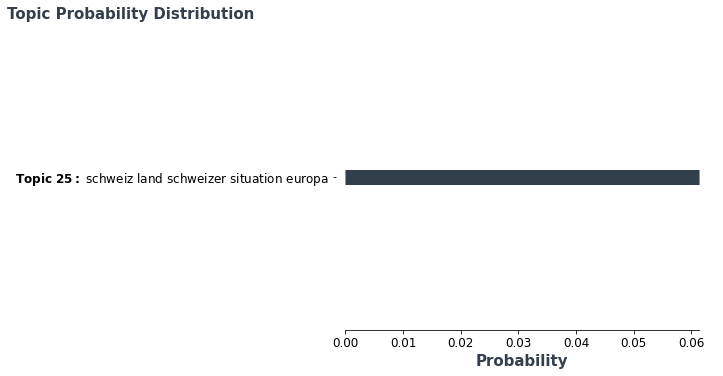

In [ ]:
# TODO run only when the model has probabilities
topic_model.visualize_distribution(probs[0])

# **Model serialization**
The model and its internal settings can easily be saved. Note that the documents and embeddings will not be saved. However, UMAP and HDBSCAN will be saved. 

In [ ]:
# Save model
#topic_model.save("german_all_68Topics")	

In [ ]:
# Load model
#my_model = BERTopic.load("german_all_68Topics")	

# **Topic Reduction**
Finally, we can also reduce the number of topics after having trained a BERTopic model. The advantage of doing so, 
is that you can decide the number of topics after knowing how many are actually created. It is difficult to 
predict before training your model how many topics that are in your documents and how many will be extracted. 
Instead, we can decide afterwards how many topics seems realistic:





In [ ]:
#new_topics, new_probs = topic_model.reduce_topics(data_ready, topics, probs, nr_topics=20)


The reasoning for putting `docs`, `topics`, and `probs` as parameters is that these values are not saved within 
BERTopic on purpose. If you were to have a million documents, it seems very inefficient to save those in BERTopic 
instead of a dedicated database.  

Check how the 1st and 2nd topics look after the reduction.

In [ ]:
topic_model.get_topic(0)[:10]

[('landwirtschaft', 0.08577664244004907),
 ('produktion', 0.0263893288154515),
 ('produzenten', 0.019942519321481344),
 ('direktzahlungen', 0.015899323797767928),
 ('lebensmitteln', 0.01211884452571607),
 ('produkte', 0.01156503297979251),
 ('land', 0.01114058003530868),
 ('umweltschutz', 0.009064228523241324),
 ('bauernverbande', 0.008869118361029155),
 ('preise', 0.006497233450923463)]

In [ ]:
topic_model.get_topic(1)[:10]

[('wintersession', 0.09234259179695854),
 ('eisberge', 0.042003127961541604),
 ('einjaehrige', 0.03554132037925467),
 ('januar', 0.025441555865258363),
 ('oberholzer', 0.019507871168474317),
 ('vorsteuer', 0.019507871168474317),
 ('schnee', 0.019507871168474317),
 ('kombiniert', 0.019507871168474317),
 ('traktandierung', 0.019507871168474317),
 ('leutenegger', 0.019507871168474317)]

Again the model is stocastich and the topics might differ across runs. However, in this run we can see that topic 0 and topic 1 has the same 10 words as before reduction.

# **Topic Representation**
When you have trained a model and viewed the topics and the words that represent them,
you might not be satisfied with the representation. Perhaps you forgot to remove
stop_words or you want to try out a different n_gram_range. We can use the function `update_topics` to update 
the topic representation with new parameters for `c-TF-IDF`: 


In [ ]:
#topic_model.update_topics(data_ready, topics, n_gram_range=(1, 3))

# **Search Topics**
After having trained our model, we can use `find_topics` to search for topics that are similar 
to an input search_term. Here, we are going to be searching for topics that closely relate the 
search term "europa". Then, we extract the most similar topic and check the results: 

In [ ]:
similar_topics, similarity = topic_model.find_topics("europa", top_n=5); similar_topics

[2, 24, 25, 1, 39]

In [ ]:
print(similar_topics, similarity)

[2, 24, 25, 1, 39] [0.9558314503610132, 0.8895447721390087, 0.6193717474390701, 0.5293934085706786, 0.4848871655449741]


Here we can see the topics that talked about similar terms to "europa".

In [ ]:
for i in similar_topics:
  print(topic_model.get_topic(i))

[('europa', 0.050708082249866865), ('europarate', 0.03512578857648165), ('land', 0.01143055881346744), ('welt', 0.009859736078946784), ('bruessel', 0.0079653870042776), ('lohnschutze', 0.007892354278161769), ('dafuer', 0.007275035980973534), ('europaweit', 0.0071180674736852235), ('deutschland', 0.006802997223298504), ('einsetzt', 0.006802997223298504)]
[('europa', 0.05405496525972164), ('europarate', 0.04576512629140827), ('lokomotiven', 0.028306841748236118), ('braeuchten', 0.025855122209788188), ('europaeische', 0.01971984751490603), ('bundeskanzlei', 0.01954134852316274), ('frauen', 0.01739447329454167), ('antrage', 0.016629596926929665), ('konzept', 0.012909693026714245), ('uebernehman', 0.012006101856982141)]
[('schweiz', 0.016547823536542737), ('land', 0.008044359069686036), ('schweizer', 0.00802423620952574), ('situation', 0.0062420304889567995), ('europa', 0.00577231718843126), ('welt', 0.0055255423670138686), ('europarate', 0.005331357689243837), ('bundesrate', 0.005232900168

Topics that talked about similar terms to "alkohol".

In [ ]:
similar_topics, similarity = topic_model.find_topics("alkohol", top_n=5); similar_topics

[6, 13, 52, 7, 12]

In [ ]:
print(similar_topics, similarity)

[6, 13, 52, 7, 12] [0.7925337880404226, 0.6354515787110857, 0.5807793227919569, 0.5772124925613986, 0.5576625581203944]


Here we can see the topics that talked about similar terms to "europa".

In [ ]:
for i in similar_topics:
  print(topic_model.get_topic(i))

[('alcopop', 0.1429733247302968), ('dope', 0.05512218757559396), ('alkohol', 0.03503093721297675), ('bierkonsum', 0.02844692896831125), ('bierpop', 0.02844692896831125), ('sondersteu', 0.02844692896831125), ('alkoholika', 0.02844692896831125), ('bier', 0.027222749936601544), ('steuer', 0.026010661936246064), ('sondersteuer', 0.0189646193122075)]
[('drogenpolitik', 0.12593500045126388), ('vizedirektor', 0.045622187318624274), ('medikament', 0.04050041012236853), ('heilmittel', 0.02875729284318197), ('apotheken', 0.025002908350340115), ('doping', 0.01917152856212131), ('therapiezwecken', 0.01917152856212131), ('therapieabbruch', 0.01917152856212131), ('dopingfrage', 0.01917152856212131), ('leistungsabbau', 0.01917152856212131)]
[('missbrauch', 0.05061668559577245), ('scheidung', 0.037618963090134905), ('wagt', 0.026207544095021053), ('frappanter', 0.026207544095021053), ('unterschaetzte', 0.026207544095021053), ('piraten', 0.026207544095021053), ('unsinnig', 0.026207544095021053), ('nebe